In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale

from pysal.region.maxp import Maxp
from pysal.weights import Queen, KNN

import matplotlib.pyplot as plt
%matplotlib inline

## Data prep

In [14]:
# dataset can be created with https://github.com/knaaptime/tstracts
store = pd.HDFStore('data/la_msa_data.h5')
attrs = store.study_data
shp = gpd.GeoDataFrame(store.study_tracts) # need to reinitialize as Geodataframe

In [15]:
attrs.head()

,geoid,year,pop,pct_lths,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,...,pct_poverty,median_home_value,pct_owner_occupied,median_contract_rent,vacancy_rate,median_household_income,pct_foreign_born,pct_single_mother,housing_units,pct_new_housing_units
3696,06037101110,1980.0,587.090269,61.274509,11.507936,85.296995,0.614955,10.496157,2.040531,14.703005,...,7.239033,227403.569836,75.739403,709.660018,4.975313,59844.338027,8.972746,7.089152,216.045944,0.645651
3697,06037101122,1980.0,6371.203086,61.266336,11.526932,85.299761,0.614342,10.493172,2.042991,14.700239,...,7.234324,227454.095720,75.759869,709.827868,4.969038,59862.053031,8.976141,7.084510,2344.410583,0.645923
3698,06037101210,1980.0,2362.739722,68.875969,9.689922,79.305383,0.184957,16.789971,1.746815,20.694617,...,17.788966,178960.366848,29.279279,630.200006,6.285178,37535.261123,11.652281,19.719473,1035.216064,0.566604
3699,06037101220,1980.0,2503.260114,68.875970,9.689922,79.305386,0.184957,16.789972,1.746815,20.694614,...,17.788966,178960.359979,29.279279,630.200006,6.285178,37535.260904,11.652282,19.719472,1096.783936,0.566604
3700,06037101300,1980.0,3829.761102,57.142858,21.107545,86.795366,0.283140,8.880309,3.371943,13.204634,...,4.736980,251282.671384,86.818846,876.800038,1.451379,69346.659726,10.810811,4.792043,1358.406860,0.798258




`attrs` contains several important tract-level demographic variables from the LTDB database (constructed from https://github.com/knaaptime/tstracts). Currently the data are a timeseries in long-form, so each tract is represented in the dataset 5 times: once each for for 1980, 1990, 2000, 2010, and 2015. Ignoring the temporal dimension for now, we'll use only the 2015 data for a subset of the attributes: race, income, education, and housing price

In [16]:
income = attrs[['geoid','median_household_income', 'year']]
income = income.pivot(index='geoid', columns='year', values='median_household_income')
income = income.dropna()

In [17]:
# subset the data to 2015, keep a handful of variables, and drop missing observations

attrs = attrs[attrs.year == 2015]
attrs = attrs[['geoid', 'year', 'pct_bachelor_or_greater', 'pct_white',
           'pct_black', 'pct_hispanic', 'pct_asian', 'pct_minority',
           'median_household_income', 'median_home_value']]
attrs = attrs.dropna()

In [18]:
# keep the tract FIPS as the identifier, drop the useless 'year' variable, and scale the data w/ min-max

attrs.set_index('geoid', inplace=True)
attrs.drop('year', axis=1, inplace=True)
attrs = attrs.transform(minmax_scale)

In [21]:
# make sure geo and attribute data are in same order to avoide linking weights by ID
attrs.sort_index(inplace=True)
shp.set_index('GEOID', inplace=True)
shp.sort_index(inplace=True)

In [23]:
attrs.head()

,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,median_household_income,median_home_value
geoid,,,,,,,,
06037101110,0.219321,0.556799,0.014519,0.337065,0.084603,0.443201,0.161688,0.182312
06037101122,0.307796,0.752355,0.005149,0.123974,0.106005,0.247645,0.400201,0.253920
06037101210,0.187990,0.417035,0.037836,0.487759,0.016538,0.582965,0.114613,0.154875
06037101220,0.224474,0.538939,0.023357,0.259132,0.156818,0.461061,0.121456,0.181005
06037101300,0.351540,0.788662,0.009991,0.103855,0.099898,0.211338,0.288696,0.228493


In [25]:
shp = shp[ shp.index.isin(attrs.index)]
W = Queen.from_dataframe(shp)

/Users/knaaptime/anaconda/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 3 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/knaaptime/anaconda/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 06037620201, 06059062900, 06059063006
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [28]:
# maybe a way to drop islands in pysal, but manually here
shp = shp[ ~shp.index.isin(['06059063006', '06059062900', '06037620201'])]
W = Queen.from_dataframe(shp)
K = KNN.from_dataframe(shp, k=5)
# W.transform = 'b' # maxp requires binary weights

In [29]:
# drop islands from the attributes too
attrs = attrs.drop(['06059063006', '06059062900', '06037620201'])
income = income.drop(['06059063006', '06059062900', '06037620201'])

In [43]:
income.head()
income.sort_index(inplace=True)

In [44]:
income.values

array([[  59844.3380272 ,   84164.59426985,   57225.03853882,
          56134.73426119,   50694.        ],
       [  59862.0530314 ,   84170.4321021 ,   73609.26093829,
          87493.05059834,  107400.        ],
       [  37535.2611234 ,   50920.24498291,   43329.27912645,
          42864.40959938,   39502.        ],
       ..., 
       [  88584.2008768 ,  101228.31067232,   81757.33011628,
          93529.26560874,   74784.        ],
       [  52427.1614522 ,   61665.1127089 ,   49756.89367239,
          47532.0680281 ,   54806.        ],
       [  52427.1576984 ,   61665.10885637,   59570.36084851,
          76142.40101457,   82500.        ]])

In [12]:
# write the attribute data to CSV since Python2 doesn't like HDF5 created w/ py3
attrs.to_csv('data/la_data.csv')
shp.to_file('data/la_msa.shp')

## Kmeans and Hierarchical (non-spatial)

In [33]:
# fit non-spatial clusters

kmeans = KMeans(n_clusters=10).fit(attrs)
hierarchical = AgglomerativeClustering(n_clusters=10).fit(attrs)

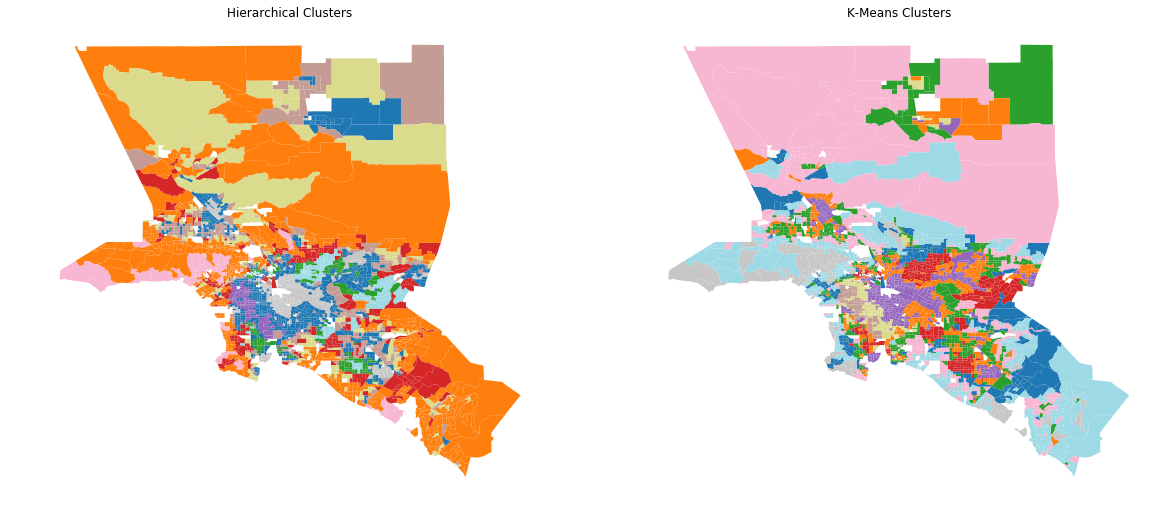

In [35]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))

ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title("Hierarchical Clusters")

ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title("K-Means Clusters")


shp.merge(attrs.assign(cluster = hierarchical.labels_), left_index=True, right_index=True).plot(column="cluster", cmap="tab20", categorical=True, ax=ax1)
shp.merge(attrs.assign(cluster = kmeans.labels_), left_index=True, right_index=True).plot(column="cluster", cmap='tab20', categorical=True, ax=ax2)

## Max-p

In [53]:
maxp_clusters = Maxp(W, attrs.values, floor = 50, floor_variable = np.ones((2786, 1)), initial = 500)

No initial solution found


## Hierarchical w/ Spatial Constraints

In [31]:
ward = AgglomerativeClustering(n_clusters=10, linkage='ward',
                               connectivity=W.full()[0]).fit(attrs)

/Users/knaaptime/anaconda/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


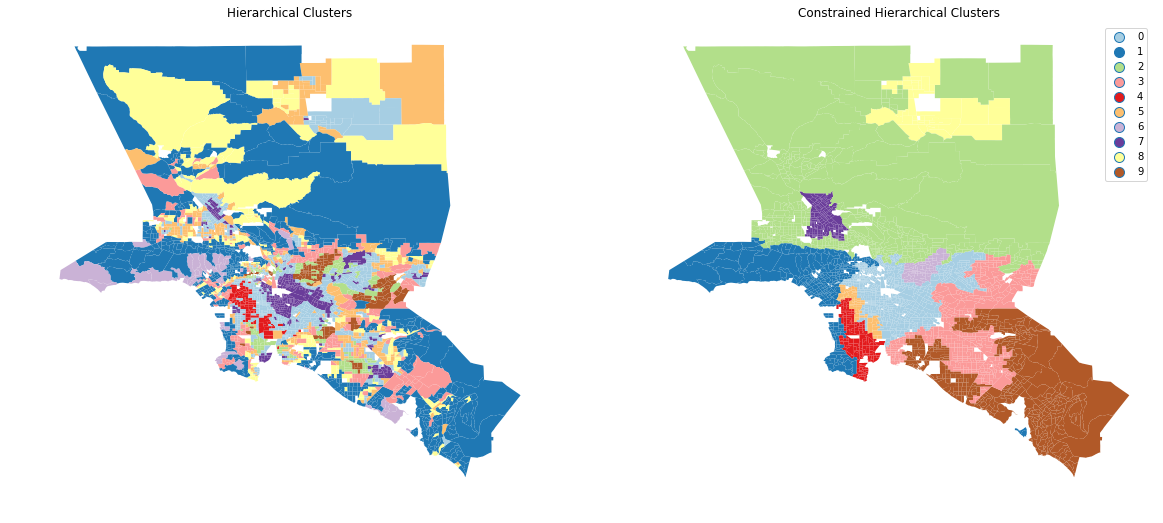

In [37]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))

ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title("Hierarchical Clusters")

ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title("Spatially Constrained Hierarchical Clusters")


shp.merge(attrs.assign(cluster = hierarchical.labels_), left_index=True, right_index=True).plot(column="cluster", categorical=True, ax=ax1, cmap='Paired')
shp.merge(attrs.assign(cluster = ward.labels_), left_index=True, right_index=True).plot(column="cluster", categorical=True, legend=True, cmap='Paired', linewidth=0, ax=ax2)

Two issues here:

- Maxp gives no result; tried with queen and rook, maybe try distance-based?
    - ** Update** - it appears the lack of results here was also due to misalignment with the weights matrix. I can get results when using sorted weights matrix and cranking the `floor` down to 3, but the result is incomprehensible with the huge number of clusters. Need to keep experimenting  


- Results from spatially constrained agglomerative clustering are a little weird. Tried varying K, contiguity, and W-transforms, no change in results. Maybe adding connectivity matrix imposes some kind of soft constraint? (like [here](https://arxiv.org/abs/1707.03897) but with no control over $\alpha$?)
    - **Update** - it looks like the weirdness was induced by the weights matrix... apparently using the `idVariable` argument when constructing the weights matrix doesn't hold up when running the clustering algorithm (i.e. the neighbors are assigned incorrectly). Instead, we should omit the idVariable and sort the shapefile and the attributes by their indexes, which gives proper alignment

In [48]:
maxp_clusters.area2region

{'06037232110': 0,
 '06037232300': 44,
 '06037232120': 0,
 '06037910606': 1,
 '06037910605': 1,
 '06037910602': 1,
 '06037541605': 2,
 '06037542000': 2,
 '06037542105': 204,
 '06037219010': 3,
 '06037219300': 3,
 '06037234200': 3,
 '06037432601': 4,
 '06037432500': 4,
 '06037432602': 4,
 '06037576403': 5,
 '06037575202': 161,
 '06037576503': 5,
 '06037650701': 489,
 '06037651201': 6,
 '06037651102': 523,
 '06037460100': 221,
 '06037462500': 470,
 '06037930101': 7,
 '06037208401': 324,
 '06037208501': 388,
 '06037208502': 8,
 '06037535200': 9,
 '06037240020': 717,
 '06037240700': 9,
 '06037122120': 10,
 '06037123020': 10,
 '06037122121': 10,
 '06037541802': 11,
 '06037542103': 2,
 '06037553702': 699,
 '06037141700': 722,
 '06037143902': 12,
 '06037141102': 12,
 '06037533901': 533,
 '06037533902': 13,
 '06037534101': 533,
 '06037920115': 435,
 '06037920112': 14,
 '06037920111': 120,
 '06037800327': 15,
 '06037800329': 15,
 '06037800326': 15,
 '06037134101': 16,
 '06037134720': 16,
 '0603

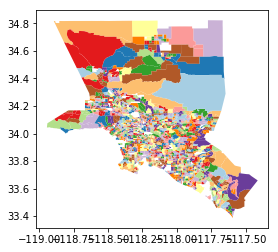

In [49]:
shp.merge(attrs.assign(cluster = maxp_clusters.area2region), left_index=True, right_index=True).plot(column="cluster", categorical=True,  cmap='Paired')
